# Beoordeling Tijdreeksmodellen
*Auteurs: O.N. Ebbens (Artesia), D.A. Brakenhoff (Artesia)*

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. Dit notebook laat zien welke methoden hiervoor gebruikt kunnen worden geillustreerd met voorbeelden.

### Inhoudsopgave

- [Visuele beoordeling](#visueel)  # Onno
- [Fit statistieken](#fit)  # D structuur, Onno: NSE
  - [Validatie](#validatie) %% wordt onderdeel van fit statistiek. Kan je een model valideren, heet het validatie/verificatie/..?
- [Diagnostische toetsen](#betrouwbaarheid)  # Onno
- [Correlatie modelparameters](#correlatie)  # D
- [Hydrologische beoordeling](#hydrologische beoordeling)
  - [Hydrologie](#hydrologie) # gain positief # D: gain plaatje, verdampingsfactor logisch?, drainagebasis?
  - [Eigenschappen responsfunctie](#geheugen) %% onderdeel van hydrologische beoordeling  # Onno: af
  - [Ruimtelijke beoordeling](#ruimtelijk)  # Invloed winning ruimtelijk

## Introductie

Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden gesteld voor het beoordelen van het model. 

Van Geer (2012) overzicht valkuilen etc.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
import pastas as ps
import datetime as dt
from matplotlib.gridspec import GridSpec
import pyproj
import contextily as ctx
from scipy.stats import norm, probplot, shapiro, normaltest

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
ps.show_versions(numba=True)

Python version: 3.8.2 (default, Mar 25 2020, 17:03:02) 
[GCC 7.3.0]
Numpy version: 1.19.2
Scipy version: 1.6.0
Pandas version: 1.2.0
Pastas version: 0.17.0b
Matplotlib version: 3.3.3
numba version: 0.52.0


In [2]:
# hulpfuncties en instellingen voor tabelweergave
cmap = plt.get_cmap("RdBu")
norma = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)


def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norma(val)))
    return f"background-color: {color}"


def ctxt(val):
    bg = cmap(norma(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

## Visuele beoordeling<a name="visueel"></a>

Het visualiseren van de resultaten van een tijdreeksmodel is een eerste eenvoudige methode om het tijdreeksmodel te beoordelen. De modelsimulatie wordt met de metingen vergeleken in een grafiek. Het verschil tussen de modelsimulatie en de metingen wordt ook vaak in een tweede grafiek gepresenteerd.

<hr>

Een voorbeeld van een visuele beoordeling wordt gepresenteerd aan de hand van een voorbeeld model. In dit tijdreeksmodel wordt de grondwaterstand verklaard aan de hand van neerslag en verdamping. In onderstaande figuur wordt de modelsimulatie (blauwe lijn) vergeleken met de metingen (zwarte punten) in de bovenste grafiek. De residuen (oranje lijn) zijn in de onderste grafiek weergegeven. 

Uit de figuur is te zien dat de simulatie en de metingen goed met elkaar overeen komen. Ook is duidelijk dat de verschillen tussen het model en de metingen vooral onstaan bij de extremen: de dalen in de zomer en de pieken in de winter.

In [3]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")

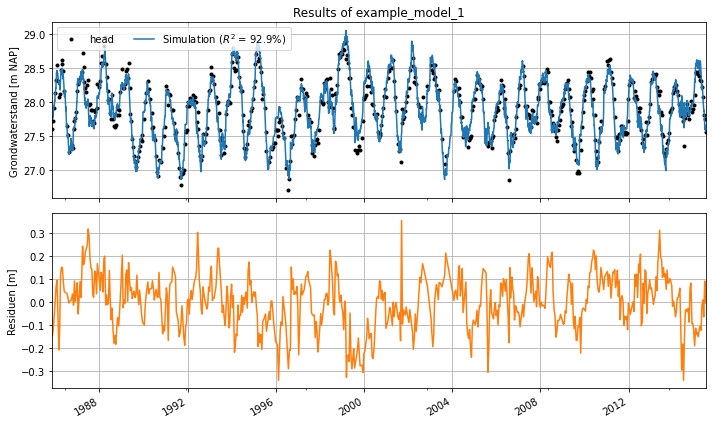

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ml1.plot(ax=ax1, legend=False)
ax1.set_ylabel('Grondwaterstand [m NAP]')
ax1.grid()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc="upper left", ncol=2)

ml1.residuals().plot(ax=ax2, color="C1", label="residuals")
ax2.set_ylabel('Residuen [m]')
ax2.grid()
fig.tight_layout()

<hr>

## Fit statistieken<a name="fit"></a>

Naast de visuele vergelijking van gemodelleerde en gemeten grondwaterstanden bestaan er ook verschillende statistieken die iets zeggen over de fit van de gemodelleerde grondwaterstand ten opzichte van de gemeten grondwaterstanden. Er zijn globaal twee categoriën in deze statistieken. Er zijn statistieken die de modelfout (de residuen) uitdrukken als een getal, waarbij een kleinere fout betekent dat het model beter overeenkomt met de metingen. De andere categorie betreft statistieken die de "goodness-of-fit" uit te drukken als een getal, waarbij een waarde van 1.0 of 100% een perfecte overeenkomst betekent tussen model en metingen.

%%Referenties naar fit statistieken opnemen%% 

Een aantal veelgebruikte fit statistieken zijn:

**som van de kwadratische fout / sum of the squares of the error**

$\text{SSE} = \sum_{i=1}^{N}(x_i - y_i)^2$


**gemiddelde absolute fout / mean absolute error**


$\text{MAE} = \sum_{i=1}^{N}\frac{|x_i - y_i|}{N}$ 


**wortel van de kwadratisch gemiddelde fout / root mean squared error** 


$\text{RMSE} = \sqrt{\sum_{i=1}^{N}\frac{ (x_i - y_i)^2}{N}}$


**verklaarde variantie / explained variance percentage**


$\text{EVP} = \frac{\sigma_h^2 - \sigma_r^2}{\sigma_h^2} * 100$


**determinatiecoëfficiënt / r-squared**


$R^2 = 1-  \frac{\sum_{i=1}^{N}(x_i - y_i)^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$


**Nash-Sutcliffe model efficiency**


$\text{NSE} = 1-  \frac{\sum_{i=1}^{N}(x_i - y_{i, sim})^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$


Waarbij 

- $N$: het aantal metingen
- $N_{param}$: het aantal vrije parameters
- $x_i$ en $y_i$: de gemeten en de gemodelleerde grondwaterstand op tijdstip $i$, respectievelijk
- $y_{i, sim}$: de voorspelde grondwaterstand op tijdstip $i$ door het model
- $\sigma_h^2$ en $\sigma_r^2$: de  in de gemeten grondwaterstanden en de variantie van de residuën, respectievelijk.

**Verschil $R^2$ en $\text{NSE}$**

De "Nash-Sutcliffe Efficiëncy" wordt vaak gebruikt voor het beoordelen van de voorspelling van een model. De "R-squared" wordt meestal gebruikt om de "goodness-of-fit" te berekenen bij de kalibratie. Het verschil tussen deze twee statistieken is dat de NSE negatief kan worden, omdat de gekwadrateerde fout van de modelvoorspelling groter kan zijn dan de totale gekwadrateerde som. In het geval van de $R^2$ is het slechtst mogelijke model in theorie het gemiddelde van de metingen waardoor de waarde van $R^2$ nooit lager kan worden dan 0.

**Kenmerken fit statistieken**

In onderstaande tabel zijn een aantal kenmerken van de fit statistieken opgenomen zoals de minimale en maximale waardes en de waarde bij een optimale fit (een perfecte overeenkomst tussen model en metingen).

| parameter              | waarde bij optimale fit | minimum  | maximum  |
|------------------------|-------------------------|----------|----------|
| $\text{sse}$           | 0                       | 0        | $\infty$ |
| $\text{mae}$           | 0                       | 0        | $\infty$ |
| $\text{rmse}$          | 0                       | 0        | $\infty$ |
| $\text{evp}$           | 100%                    | 0        | 100      |
| $R^2$                  | 1                       | 0        | 1        |
| $\text{nse}$           | 1                       | $-\infty$| 1        |

%% Misschien wat onduidelijk het verschil tussen r-squared en NSE, komt hiervandaan https://stats.stackexchange.com/questions/185898/difference-between-nash-sutcliffe-efficiency-and-coefficient-of-determination %%
%% openstaande vragen:
- waarom zit de correctie voor aantal parameters bij de berekening van r-squared? -> issue pastas
- verschil verklaarde variantie/r-squared/NSE, hoe op te nemen in deze uitleg?
%%

<hr>

Voor het voorbeeld model zijn de hierboven genoemde statistieken berekend. De gemiddelde absolute modelfout bedraagt ca. 9 cm. De fit-statistieken geven aan dat het model goed overeenkomt met de metingen; de verklaarde variantie (EVP) is 93%. 

In [5]:
# fit statistics kunnen in pastas worden opgevraagd met `ml.stats.<naam statische parameter>()`
stats = [
    "Mean absolute error (mae)",
    "Root mean squared error (rmse)",
    "Sum of the squares of the error (sse)",
    "Explained variance percentage (evp)",
    "R-squared (rsq)"
]

df = pd.DataFrame(index=stats, columns=["waarde", "eenheid"])
df.loc[stats[0], :] = ml1.stats.mae(), "m"
df.loc[stats[1], :] = ml1.stats.rmse(), "m"
df.loc[stats[2], :] = ml1.stats.sse(), "m$^2$"
df.loc[stats[3], :] = ml1.stats.evp(), "%"
df.loc[stats[4], :] = ml1.stats.rsq(), "-"

df.style.set_precision(3)

,waarde,eenheid
Mean absolute error (mae),0.090,m
Root mean squared error (rmse),0.114,m
Sum of the squares of the error (sse),8.431,m$^2$
Explained variance percentage (evp),92.926,%
R-squared (rsq),0.929,-


<hr>

### Overfitting

Als er meer verklarende variabelen (en daarmee modelparameters) aan een tijdreeksmodel worden toegevoegd wordt de fit over het algemeen beter, zelfs als de verklarende variabele helemaal geen invloed heeft op de grondwaterstand. Het model kan deze extra vrijheidsgraden (parameters) namelijk gebruiken om het model beter op de metingen te fitten. Het toevoegen van een niet-relevante verklarende variabele zorgt niet voor een verbetering in de voorspellende waarde van het model. Het fenomeen waarbij meer parameters aan een model worden toegevoegd dan gerechtvaardigd is op basis van de data heet overfitting. 

Dit is belangrijk omdat het dus niet altijd mogelijk is om op basis van de fit statistieken aan te geven of het model verbetert na het toevoegen van een verklarende variabele. De volgende methode voor model beoordeling kan gebruikt worden om te controleren of er sprake is van overfitting.

## Train-test split<a name="validatie"></a>  %% hoe noem je dit?!%%

Een methode om modellen te beoordelen is om de dataset in een trainings-deel en een test-deel op te splitsen. Daarbij wordt een tijdreeks opgeknipt in twee delen. Een deel van de metingen wordt gebruikt om het model te kalibreren en wordt de trainings-dataset genoemd. Vervolgens wordt het gekalibreerde model gebruikt om een simulatie te berekenen voor de tweede periode. Dit deel wordt de test-dataset genoemd. De simulatie wordt vergeleken met de metingen om te beoordelen of het model ook goede resultaten oplevert voor het deel waar het niet op gekalibreerd is. Een tijdreeks moet voldoende lang zijn en voldoende metingen bevatten om op te splitsen trainings-deel en een test-deel.

Als het model goed presteert in de test-periode dan is het model dat is afgeleid op basis van de trainings-periode goed genoeg om de grondwaterstanden te voorspellen in die periode. Dat geeft vertrouwen dat het model goed presteert, maar dat betekent niet per definitie dat het model ook in de toekomst goede voorspellingen zal geven. Als er in de toekomst iets structureel veranderd in het systeem (b.v. een onttrekking die start maar niet in het model is opgenomen), dan zal het model dat uiteraard niet goed voorspellen. 

Als het model een goede fit heeft in de trainings-periode maar niet in de test-periode, dan is het model geen goede voorspeller van de grondwaterstand. Dit kan verschillende oorzaken hebbben maar geeft aan dat het model mogelijk niet geschikt is voor verder het gestelde doel. Oorzaken zijn bijvoorbeeld veranderingen in het systeem die tijdens de test-periode hebben plaatsgevonden, zoals de start van een nieuwe onttrekking of het dempen van een watergang, of het meenemen van een invloed in het model die tijdens te trainingsperiode nog niet actief was.

Voor een uitgebreide analyse van een set aan tijdreeksmodellen met deze methode, inclusief een beschouwing van bijbehorende fit-statistieken, zie [Knotters (2012)](#referenties).

%%voorbeeld toevoegen model wat wel goed fit maar slechte validatie (model van raoul met trend)%%

<hr>

De test-train split methode is uitgevoerd voor het voorbeeld model hierboven. De dataset is in twee periodes opgesplitst. In het eerste voorbeeld wordt het model getraind (gefit) op de de eerste periode, en getest op de tweede. In het tweede voorbeeld is dat omgedraaid. Uit onderstaande figuren is zichtbaar dat het model in beide gevallen een goede simulatie oplevert van de grondwaterstanden in de testperiode. 

In [6]:
# train het model op periode 1985 - 2000, test het model op de periode 2005 - 2016
ml_train1 = ml1.copy()
ml_train1.solve(tmin='1985', tmax='1999', report=False)

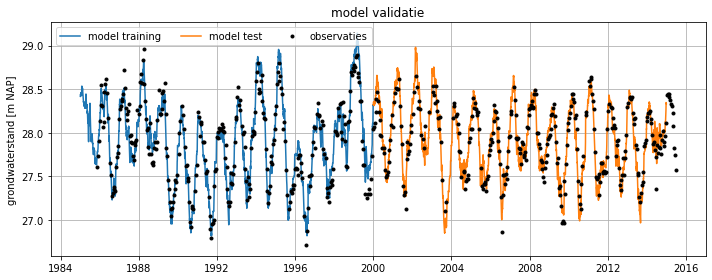

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ml_train1.simulate(tmin='1985', tmax='2000'), label='model training')
ax.plot(ml_train1.simulate(tmin='2000', tmax='2015'), label='model test')
ax.plot(ml1.oseries.series_original, ls='', marker='.',
        label='observaties', color='k')
ax.legend(loc="upper left", ncol=3)
ax.grid()
ax.set_title('model validatie')
ax.set_ylabel('grondwaterstand [m NAP]')
fig.tight_layout()

In [8]:
# train het model op periode 2005 - 2020, test het model op de periode 1990 - 2005
ml_train2 = ml1.copy()
ml_train2.solve(tmin='2000', tmax='2015', report=False)

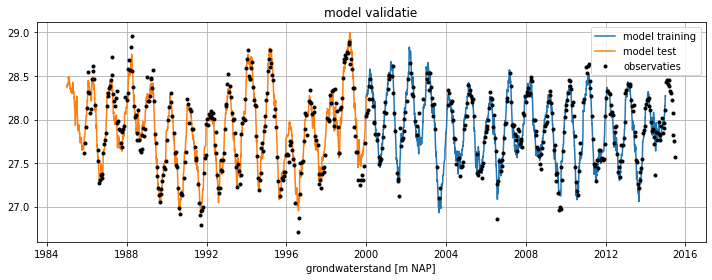

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ml_train2.simulate(tmin='2000', tmax='2015'), label='model training')
ax.plot(ml_train2.simulate(tmin='1985', tmax='2000'), label='model test')
ax.plot(ml1.oseries.series_original, ls='',
        marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_xlabel('grondwaterstand [m NAP]')
fig.tight_layout()

De fit statistieken zijn opnieuw berekend voor beide testperiodes. In dit geval is in plaats van de $R^2$ de $\text{NSE}$ toegepast omdat het om een voorspelling met het model gaat. De resultaten laten net als de grafieken hierboven zien dat het model in beide gevallen goed presteert:

- testperiode 1990 - 2004: NSE = 0.93
- testperiode 2005 - 2020: NSE = 0.91

In [10]:
sim = ml_train2.simulate(tmin='1990', tmax='2005')
obs = ml_train2.oseries.series['1990':'2004']

stats = [
    "Mean absolute error (mae)",
    "Root mean squared error (rmse)",
    "Sum of squares of the error (sse)",
    "Explained variance percentage (evp)",
    "Nash-Sutcliffe model efficiency (nse)"
]

df = pd.DataFrame(index=stats, columns=["1985-2000", "2000-2015", "eenheid"])

# statistieken periode 1985 - 2000
df.loc[stats[0], "1985-2000"] = ps.stats.mae(obs=obs, sim=sim)
df.loc[stats[1], "1985-2000"] = ps.stats.rmse(obs=obs, sim=sim)
df.loc[stats[2], "1985-2000"] = ps.stats.sse(obs=obs, sim=sim)
df.loc[stats[3], "1985-2000"] = ps.stats.evp(obs=obs, sim=sim)
df.loc[stats[4], "1985-2000"] = ps.stats.nse(obs=obs, sim=sim)


# statistieken periode 2000 - 2015
sim = ml_train1.simulate(tmin='2005', tmax='2020')
obs = ml_train1.oseries.series['2005':'2019']
df.loc[stats[0], "2000-2015"] = ps.stats.mae(obs=obs, sim=sim)
df.loc[stats[1], "2000-2015"] = ps.stats.rmse(obs=obs, sim=sim)
df.loc[stats[2], "2000-2015"] = ps.stats.sse(obs=obs, sim=sim)
df.loc[stats[3], "2000-2015"] = ps.stats.evp(obs=obs, sim=sim)
df.loc[stats[4], "2000-2015"] = ps.stats.nse(obs=obs, sim=sim)

df.loc[:, "eenheid"] = ["m", "m", "m$^2$", "%", "-"]

df.style.set_precision(3).set_caption("Statistieken voor test-periodes")

,1985-2000,2000-2015,eenheid
Mean absolute error (mae),0.096,0.091,m
Root mean squared error (rmse),0.123,0.112,m
Sum of squares of the error (sse),4.684,3.022,m$^2$
Explained variance percentage (evp),93.549,91.021,%
Nash-Sutcliffe model efficiency (nse),0.929,0.910,-


<hr>

## Betrouwbaarheid modelparameters<a name="betrouwbaarheid"></a>

Tijdreeksmodellen kunnen ook beoordeeld worden aan de hand van de berekende onzekerheden van de modelparameters. Het is goed voor te stellen dat een model waarvan de parameters lastig te bepalen zijn (de parameters zijn onzeker) minder betrouwbaar wordt geacht dan een model waarbij de parameters goed vast te stellen zijn (met een kleine onzekerheid).




Naast de beoordeling van de model fit is het ook van belang om te kijken naar de modelparameters. Externe invloeden worden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten. Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een noisemodel worden toegevoegd. In het voorbeeld hieronder zijn de parameters weergegeven van een tijdreeksmodel met recharge als externe invloed. 

In [11]:
# voorbeeld parameters van model met recharge
ml1.parameters[['initial', 'optimal', 'pmin', 'pmax', 'stderr']]

,initial,optimal,pmin,pmax,stderr
recharge_A,215.674528,686.247379,0.00001,21567.452806,36.404207
recharge_a,10.000000,159.386066,0.01000,1000.000000,7.990858
recharge_f,-1.000000,-1.305352,-2.00000,0.000000,0.052736
constant_d,27.900078,27.920125,NaN,NaN,0.058681
noise_alpha,15.000000,49.911881,0.00001,5000.000000,5.918768


Per parameters zijn de volgende waarden weergegeven:
- **initial**: de initiële waarde
- **optimal**: de geoptimaliseerde waarde
- **pmin en pmax**: de bandbreedte waarbinnen de parameters worden geoptimaliseerd
- **stderr**: de standaarddeviatie van de geoptimaliseerde parameter

De berekende standaarddeviaties zijn alleen betrouwbaar als aan een aantal voorwaarden wordt voldaan. Deze voorwaarden zijn hieronder uitgewerkt. Daaronder wordt behandeld hoe je de standaarddeviatie kan gebruiken om meer inzicht te krijgen in de modelresultaten.

<div class="alert alert-info">
    
<b>vuistregel:</b> 
    
Als de standaarddeviaties van de parameters worden gebruiktt, is een diagnostische check van het ruismodel nodig.
    
</div>





De berekende standaarddeviaties zijn betrouwbaar als aan een aantal voorwaarden wordt voldaan. De twee voorwaarden voor de met het ruismodel berekende ruis zijn dat het:
1. zich gedraagt als witte ruis met een gemiddelde van nul.
2. niet gecorreleerd is aan een verklarende tijdreeks.

Er is sprake van witte ruis wanneer:
1. er geen significante autocorrelatie in de ruis aanwezig is
2. de ruis homoscedastisch is
3. de ruis voldoet aan een, bij voorkeur normale, statistische verdeling.

### Autocorrelatie

Het kan gebeuren dat een tijdreeks gecorreleerd is met een in de tijd verschoven versie van zichzelf. Als dat het geval is spreken we van autocorrelatie. De autocorrelatie kan worden weergegeven in een autocorrelatiediagram zoals hieronder. Hierin is op de x-as de verschuiving in de tijd weergegeven (lag) en op de y-as de hierbij berekende correlatie. De autocorrelatie wordt weergegeven tot een maximale verschuiving van 1 jaar (365 dagen). De blauwe band in de grafiek geeft het 95% betrouwbaarheidsinterval weer. Wanneer 95% van de berekende autocorrelaties binnen dit interval liggen kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de reeks.

%% Vragen:
- Als het betrouwbaarheidsinterval wordt berekend op basis van de autocorrelaties en je vervolgens gaat toetsen of de autocorrelaties binnen dit betrouwbaarheidsinterval liggen dan komt deze altijd door de toets toch? Of maak ik nu een denkfout? Waar wordt de blauwe band mee berekend?
- dit model komt niet door de Runs test, enig idee waarom niet?
%%

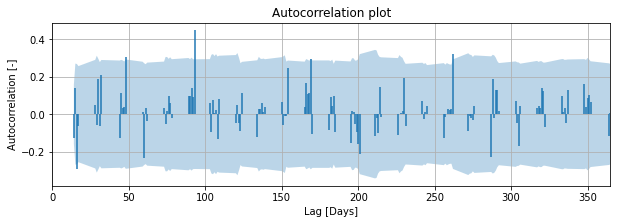

In [12]:
ax = ps.stats.plot_acf(ml1.noise(), acf_options={"max_gap": 60, "min_obs": 24},
                       figsize=(10, 3), alpha=0.01)



Naas de visuele check op autocorrelatie bestaan er ook statische toestsen om te checken of er autocorrelatie aanwezig is. Deze zijn in onderstaande tabel weergegeven. De eerste twee methodes `ljung_box` en `Durbin-Watson` zijn alleen geschikt voor equidistante tijdreeksen. In tijdreeksen van grondwaterstanden missen vaak metingen en dus zijn deze niet equidistant. Voor het checken van autocorrelatie worden daarom meestal de `Stoffer-Toloi` en de `Runs Test` gebruikt die wel kunnen omgaan met niet equidistante reeksen.


| Naam | Beschrijving | geschikt voor niet equidistante reeksen |
|:-----|:-----------------------------------------|:---------------:|
| Ljung-Box test| Deze test checkt of de autocorrelatie in een tijdreeks significant verschilt van nul| Nee |
| Durbin-Watson test | Deze test checkt de autocorrelatie bij een verschuiving van één tijdstap. | Nee |
| Stoffer-Toloi test | Deze test is vergelijkbaar met de Ljung-Box test, maar aangepast voor missende waarde | Ja |
| Runs test | Deze test checkt of de waarden in een tijdreeks willekeurig zijn zonder uit te gaan van een bepaalde kansverdeling. | Ja |


<p style="color:red">%% Hoe zit het met Stoffer-Toloi? Hoeveel data mag er missen? Kan je ook bij een frequentie waar soms iets mist toch deze test doen?%%</p>

In [13]:
alpha = 0.05

stat, p = ps.stats.stoffer_toloi(ml1.noise(), lags=15, freq="D")

print('Stoffer-Toloi test:')
if p > alpha:
    print("Nullhypothese niet verworpen, geen significante autocorrelatie. p =", p.round(2))
else:
    print("Nullhypothese verworpen")


print('\nRuns test:')
stat, p = ps.stats.runs_test(ml1.noise())

if p > alpha:
    print("Nullhypothese niet verworpen, geen significante autocorrelatie. p =", p.round(2))
else:
    print("Nullhypothese verworpen")

Stoffer-Toloi test:
Nullhypothese niet verworpen, geen significante autocorrelatie. p = 0.11

Runs test:
Nullhypothese niet verworpen, geen significante autocorrelatie. p = 0.64


### Homoscedasticiteit

Een reeks is homoscedastisch als alle waarden dezelfde eindige variantie hebben. Bij ons tijdreeksmodel betekent dit dat de ruis onafhankelijk is van de gemeten grondwaterstanden. Dit is hieronder visueel weergegeven door deze waarden tegen elkaar uit te zetten in een grafiek.

Wanneer sprake is van heteroscedasticiteit ...



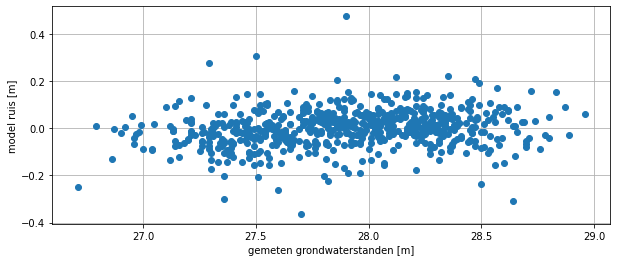

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ml1.observations(), ml1.noise(), marker="o", linestyle=" ")
ax.set_xlabel("gemeten grondwaterstanden [m]")
ax.set_ylabel("model ruis [m]")
ax.grid()

### Normale verdeling ruis

Een veelgebruikte aanname is dat de ruis normaal verdeeld is. In principe is het ook mogelijk dat er een andere kansverdeling bij de ruis hoort. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een kansverdeling. 

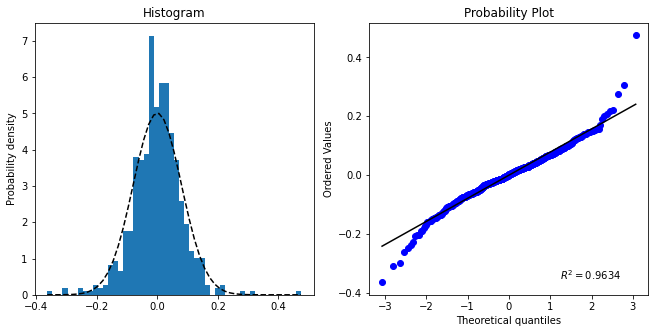

In [16]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml1.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('b')
ax2.get_lines()[1].set_color("k")

Het is een beruchte uitdaging om te bepalen of een tijdreeks normaal verdeeld is. Er bestaan wel testen maar deze zijn niet altijd betrouwbaar. Aan de ene kant geldt dat als er weinig metingen beschikbaar zijn, de afwijkingen van een normale verdeling erg sterk moeten zijn voordat de test ze kan detecteren. Aan de andere kant geldt dat bij een groot aantal metingen, hele kleine (irrelevante) afwijkingen van de normale verdeling al tot significante uitkomsten leiden.  Het is daarom lastig objectief vast te stellen of ruis normaal verdeeld is.

| Naam | Beschrijving | Geschikt voor niet equidistante tijdreeksen? |
|:-----|:------------|----------------:|
| Shapiro-Wilk | Deze test checkt of de data uit een normale verdeling is getrokken | Onbekend |
| D'Agostino | Deze test checkt of de ruis voldoet aan een normale verdeling (H0 hypothesis). | Onbekend |


%% vragen:
- werken deze testen voor niet equidistante tijdreeksen?
- waarom zijn de p-waarden zo klein bij kleine tijdstappen? Tijdstap van 70 dagen lukt het wel, gevoelsmatig wel weer heel groot.
%%

In [ ]:
stat, p = shapiro(ml.noise())

print('Shapiro-Wilk test:')
if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", np.round(p, 2))
else:
    print("Reject the Null-hypothesis. p =", np.round(p, 3))


stat, p = normaltest(ml.noise())

print("\nD'Agostino test:")
if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(3))

### Visualisatie onzekerheid modelparameters

Wanneer wordt voldaan aan bovengenoemde voorwaarden kan de standaarddeviatie van de modelparameters worden gebruikt om de betrouwbaarheid van het model in te schatten. Zoals bijvoorbeeld hieronder bij het plotten van de bandbreedte van een modelsimulatie en de bandbreedte van een responsfunctie.

In [ ]:
# Plot betrouwbaarheidsinterval
df = ml_simple.fit.prediction_interval()
fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
obs = ml_simple.oseries.series_original
sim = ml_simple.simulate()
inside = (obs > df.loc[obs.index, 0.025]) & (obs < df.loc[obs.index, 0.975])
print(
    f'metingen binnen voorspellingsinterval: {np.count_nonzero(inside) / len(inside) * 100:.1f}%')

obs.plot(ax=ax1, linestyle='', marker='.', color='k', label='meting',
         x_compat=True)
sim.plot(ax=ax1, x_compat=True, label='modelsimulatie')
ax1.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% voorspellingsinterval")
ax1.set_ylabel('m NAP')
ax1.grid()
ax1.legend(bbox_to_anchor=(0.5, -0.15), ncol=3, loc='upper center')

# plot recharge response
ax2 = fig.add_subplot(gs[0, 1])
df = ml_simple.fit.ci_step_response("gw_aanvulling", alpha=0.05, n=1000)
rch_response = ml_simple.get_step_response("gw_aanvulling", add_0=True)

rch_response.plot(ax=ax2)
ax2.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% confidence")
ax2.grid()
ax2.set_title('grondwateraanvulling response');

%% naar notebook van Raoul %%

De standaarddeviatie kan ook worden gebruikt om de betrouwbaarheid van een model te toetsen. Bijvoorbeeld door te kijken naar de grootte van de standaarddeviatie t.o.v. de geoptimaliseerde parameterwaarde. Hieronder testen we of de absolute, geoptimaliseerde parameterwaarde groter is dan 2x de standaarddeviatie. In dit geval komen alle parameters behalve de `step_d` parameter door onze test. Dit betekent dat de invloed van de steptrend een grote onzekerheid kent. 

%%Is deze check wel interessant? En we mogen deze ook helemaal niet doen volgende onze eigen analyse want de 3 voorwaarden voor witte ruis zijn niet getest%%

In [ ]:
# check of de waarde van de parameter groter is dan 2x de standaarddeviatie
parameters = ml_simple.parameters[ml_simple.parameters.vary]
parameters['optimal'].abs() > (parameters['stderr']*2)

## Parameter correlaties<a name="correlatie"></a>

Tijdens het optimaliseren van een tijdreeksmodel wordt ook de correlatie tussen de geschatte parameters berekend. Als twee parameters sterk gecorreleerd zijn betekent dat deze in de optimalisatie moeilijk van elkaar te onderscheiden zijn. Dit heeft meestal geen invloed op de voorspellende kracht van het tijdreeksmodel in zijn geheel, maar mogelijk wel op het inschatten van individuele bijdrages van de verklarende variabelen.

%% wat hier nog noemen? Multicollinearity?%%

<hr>
<p style="color:red">%% dit voorbeeld nog uitwerken met onttrekkingsreeksen die gecorreleerd zijn %%</p>

**voorbeeld problematische parameter correlaties**<br>
Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruibkaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.
<hr>

## Hydrologische beoordeling<a id='hydrologische beoordeling'></a>

Tijdreeksmodellen worden veel gebruikt om systeem-identificatie uit te voeren, waarbij de bijdrages van verschillende invloeden aan veranderingen in de stijghoogte worden ingeschat. Vanuit vraagstukken uit de praktijk wordt tijdreeksanalyse vaak toegepast op een heel meetnet, of op meerdere peilbuizen binnen een interessegebied. De hydrologische beoordeling van individiuele, maar ook hele sets van tijdreeksmodellen is interessant om uit te voeren. 

### Hydrologie<a id='hydrologie'></a>

Het beoordelen van modellen op basis van hydrologische aspecten kan allerlei vormen aannemen. De vraag daarbij is eigenlijk "is hetgeen dat ik bereken hydrologisch plausibel?". Daarbij zijn modellen die wel aan de verwachtingen voldoen net zo interessant als de modellen die daar niet aan voldoen. 

Door de modellen op hydrologische aspecten te toetsen wordt het inzicht in het systeem vergoot. 

Een 

- "Is hetgeen dat ik bereken hydrologisch plausibel?"
- Gaat de grondwaterstand omhoog als het regent, en gaat die omlaag als de onttrekking aan staat?
- Verdampingsfactor?
- 



<hr>

Als voorbeeld van een hydrologische beoordeling van een tijdreeksmodel wordt de respons van een onttrekking beschouwd. In onderstaande figuur zijn twee verschillende stapresponsen weergegeven met een onzekerheidsbandbreedte. De bandbreedte van 2x de standaardafwijking is in dit geval berekend aan de hand van de onzekerheid in de gain parameter (de parameter die het stationaire effect van de onttrekking bepaald). In de linker grafiek is de onzekerheid van de staprespons klein, met andere woorden, de parameters kunnen relatief nauwkeurig bepaald worden in de optimalisatie. In de rechter grafiek is deze onzekerheid veel groter, de invloed van de onttrekking kan dus niet nauwkeurig worden ingeschat in de optimalisatie. In dit geval betekent een positieve staprespons dat de onttrekking een verlaging van de stijghoogte veroorzaakt.


<br>
<center><img src='data/stationaire_invloed.png' width=75% alt='stationaire invloed met onzekerheid'/></center>
<center><b><em>Stationaire invloed van een onttrekking met een kleine onzekerheid (links) en een grote onzekerheid (rechts).</em></b></center>
<br>

Vanuit de hydrologie moet de onttrekking voor een daling van de grondwaterstand zorgen, maar in het geval van het onzekere model (rechts) is er een een meer dan 5%-kans dat de onttrekking een verhoging van de grondwaterstand veroorzaakt. De bandbreedte is dusdanig groot dat er een kans is dat de staprespons ook negatief kan zijn. In dat geval kunnen we stellen dat dat hydrlogisch gezien niet plausibel is, en dat dit model waarschijnlijk niet goed is. De onttrekking heeft mogelijk geen significante invloed op de stijghoogte.

<hr>


### Eigenschappen van de responsfunctie<a id='geheugen'></a>

Hieronder zijn van twee modellen de block response en de modelresultaten in één figuur geplot. Bij het eerste model is de lengte van het tijdreeksmodel een aantal maal groter dan het geheugen van de responsefunctie. Dit model voldoet daarmee aan de eis. Bij het tweede model is het geheugen van de responsfunctie langer dan de duur van het tijdreeksmodel, dit model voldoet niet aan de eis.

<hr>

#### voorbeeld geheugen 1

In [ ]:
# get response function
sm = ml_simple.stressmodels['gw_aanvulling']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16, 4))
block_resp = resp_func.block(
    ml_simple.get_parameters('gw_aanvulling'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml_simple.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=5)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_simple.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(oseries['1990':], marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=4)

<hr>

#### voorbeeld geheugen 2

In [ ]:
ml_voorbeeld = ps.io.load(os.path.join('data', 'voorbeeld_geheugen.pas'))
ml_voorbeeld.solve(report=False)

In [ ]:
# get response functie
sm = ml_voorbeeld.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16, 4))
block_resp = resp_func.block(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.97)

# plot response functie
ax.plot(pd.date_range(ml_voorbeeld.settings['tmin'], periods=len(block_resp)), block_resp,
        label='block response',
        color='orange', lw=3)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_title('modelperiode en blokresponse')

# plot t95 response functie
t95 = ml_voorbeeld.stressmodels['recharge'].rfunc.get_tmax(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_voorbeeld.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='k', label='t95', lw=3)
ax.set_ylim(ylim)

ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_voorbeeld.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml_voorbeeld.oseries.series_original,
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.legend(loc=1)

<hr>

#### bepalen geheugen van de responsfunctie

Het bepalen van het geheugen van de responsfunctie is niet altijd even vanzelfsprekend. Regelmatig worden exponentiële responsefuncties gebruikt met een horizontale asymptoot op y=0, de respons zal dus nooit gelijk zijn aan 0. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de respons 0 is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

In [ ]:
t95 = resp_func.get_tmax(ml_simple.get_parameters('gw_aanvulling'), cutoff=0.95)
print(f'geheugen (t95) -> {t95:.0f} dagen')

ax = ml_simple.plots.block_response(figsize=(8, 4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=3)

block_response = sm.rfunc.block(ml_simple.get_parameters('gw_aanvulling'))

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) < t95, hatch='/',
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('block response recharge');

### Ruimtelijke beoordeling

Een 

<hr>

Een voorbeeld van ruimtelijke beoordeling van tijdreeksmodellen wordt gegeven aan de hand van een voorbeeld uit Collenteur (%%datum%%). In die studie zijn tijdreeksmodellen afgeleid voor peilbuizen binnen een straal van 5 km rondom een drinkwater winning van Brabant Water bij Seppe. In deze tijdreeksmodellen zijn neerslag, verdamping en het onttrekkingsdebiet van winning Seppe als verklarende variabelen meegenomen. Vervolgens zijn de tijdreeksmodellen geoptimaliseerd. In onderstaande figuur zijn de berekende stationaire invloeden (ook wel bekend als de 'gain') van de winning Seppe uitgezet tegen de afstand tussen de verschillende peilbuizen en de winlocatie. Daarbij is onderscheid gemaakt tussen peilbuizen in het eerste en tweede watervoerende pakket. De verticale balken geven de onzekerheid aan, en komen overeen met 2 maal de standaardafwijking. De stationaire invloed is berekend voor een onttrekkingsdebiet van 1 miljoen m$^3$/jaar. In de figuur is ook de stationaire invloed van de onttrekking als functie van de afstand berekend met een 2-laags analytisch elementen grondwatermodel (TimML, Bakker (%%datum%%)).

<br>
<center><img src='data/drawdown_screenshot.png' alt="Berekende stationaire invloed winning Seppe als functie van de afstand bij onttrekking van 1 Mm^3/jaar" width=50% align='center' /></center>

<center><b><em>Berekende stationaire invloed winning Seppe als functie van de afstand bij onttrekking van 1 Mm^3/jaar (Bron: Collenteur, ())</em></b></center>

<br>


Elk tijdreeksmodel is onafhankelijk van de andere modellen; er wordt per model op basis van de gemeten stijghoogtes ingeschat wat de bijdrages van neerslag, verdamping en onttrekking zijn op de verandering in de grondwaterstand. Het berekende patroon van een grotere verlaging nabij de winning past goed op de theoretische invloed van een onttrekking. Ook het verschil tussen het eerste en tweede watervoerende pakket is duidelijk op te maken uit de resultaten van de tijdreeksmodellen. 

Op basis van deze resultaten is het aannemelijk dat de tijdreeksmodellen goed in staat zijn de invloed van de winning Seppe in te schatten. Het geeft vertrouwen dat deze onafhankelijke modellen een plausibel verlagingsbeeld berekenen. 

%% slechte zin%% Daarmee is het te beargumenteren dat deze modellen toegepast kunnen worden om de invloed van veranderingen in het onttrekkingsdebiet van Seppe op de grondwaterstand te berekenen.

Een hydrologische beschouwing van de resultaten van meerdere tijdreeksmodellen kan dus waardevol zijn in de beoordeling van die tijdreeksmodellen. 

<hr>

## Discussie

## Referenties<a id='referenties'></a>
- Collenteur (Seppe)
- Bakker (TimML)
- Knotter 2012
- Van Geer (2012)